## Задание 2(2)

### Тест 1 (критерий однородности Смирнова)

В качестве первого теста на однородность используем тест Колмогорова-Смирнова с гипотезами:
- $H_0$: $F_n = F_m \; (= F)$
- $H_1$: $\neg H_0$

Статистика для этого теста:
$$D_{n,m} = sup_{x \in \mathbb{R}}|F_n - F_m|$$

Тест правосторонний, поэтому
$$pvalue = 1 - K(\sqrt{\frac{nm}{n+m}} \cdot D_{n,m})$$

Примечание: о распределении kstwo подробнее по ссылке https://docs.scipy.org/doc/scipy/tutorial/stats/continuous_kstwo.html

In [221]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import ecdf, kstwo, ks_2samp, mannwhitneyu, norm
from itertools import chain

In [222]:
def print_empirical_function(sample1, sample2, label1 = None, label2 = None):
    fig, ax = plt.subplots(1, 1)
    ax.ecdf(sample1, label=label1)
    ax.ecdf(sample2, label=label2)
    ax.legend()
    plt.show()

In [223]:
def ks_test(sample1, sample2):
    n = len(sample1)
    m = len(sample2)
    
    ecdf1 = ecdf(sample1)
    ecdf2 = ecdf(sample2)
    
    sample = chain(sample1, sample2)
    diffs = np.array([ecdf1.cdf.evaluate(x) - ecdf2.cdf.evaluate(x) for x in sample])
    d = np.max(np.abs(diffs))
    
    p_value = 1 - kstwo.cdf(d, round((n * m) / (n + m)))
    return d, p_value
    
def first_test(sample1, sample2, alpha = 0.05):
    ks_scipy = ks_2samp(sample1, sample2)
    statistic, p_value_my = ks_test(sample1, sample2)
    result = "accept" if ks_scipy.pvalue > alpha else "reject"

    print("Тест Колмогорова-Смирнова")
    print(f"\tРезультат: {result}")
    print(f"\tПодробный результат:\n\t\t Statistic: {statistic} \n\t\t P-value: {p_value_my}")
    print(f"\tРезультат ks_2samp из scipy: {ks_scipy}")

### Тест 2 (критерий Манна-Уитни)

Гипотезы для этого теста:
- $H_0$: $F_1 = F_2$
- $H_1$: $\neg H_0$

Статистика:
$$U = min(U_1, U_2)$$
$$U_1 = n_1 \cdot n_2 + \frac{n_1 \cdot (n_1 + 1)}{2} - R_1$$
$$U_2 = n_1 \cdot n_2 + \frac{n_2 \cdot (n_2 + 1)}{2} - R_2$$
где $R_1$, $R_2$ - суммы рангов каждой из выборок, $n_1$, $n_2$ - объемы выборок

При больших объемах выборок, статистика стремится к нормальному распределению $N = N(\frac{n_1 n_2}{2}, \frac{n_1 n_2(n_1 + n_2 + 1)}{12})$

Тест двусторонний, поэтому
$$pvalue = 2 \cdot min(p_l, p_r) = 2 \cdot min(N(U), 1 - N(U))$$


In [224]:
def mann_whitneyu(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    combined = np.concatenate((sample1, sample2))
    sorted_indices = np.argsort(combined)
    ranks = np.zeros_like(combined, dtype=float)
    for i, idx in enumerate(sorted_indices):
        ranks[idx] = i + 1

    rank_sum = np.bincount(combined, weights=ranks)
    count = np.bincount(combined)
    for i in range(len(combined)):
        ranks[i] = rank_sum[combined[i]] / count[combined[i]]

    rank_sum1 = np.sum(ranks[:n1])
    rank_sum2 = np.sum(ranks[n1:n1+n2])

    U1 = n1 * n2 + (n1 * (n1 + 1)) / 2 - rank_sum1
    U2 = n1 * n2 + (n2 * (n2 + 1)) / 2 - rank_sum2
    U = min(U1, U2)
    
    mean = n1 * n2 / 2
    std = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
    z = (U - mean) / std
    
    p_value = 2 * min(norm.cdf(z), 1 - norm.cdf(z))
    return U, p_value

def second_test(sample1, sample2, alpha = 0.05):
    mannwhitneyu_scipy = mannwhitneyu(sample1, sample2)
    statistic, pvalue = mann_whitneyu(sample1, sample2)
    
    result = "accept" if mannwhitneyu_scipy.pvalue > alpha else "reject"
    
    print("Тест Манна-Уитни")
    print(f"\tРезультат: {result}")
    print(f"\tПодробный результат:\n\t\t Statistic: {statistic} \n\t\t P-value: {pvalue}")
    print(f"\tРезультат mannwhitneyu из scipy: {mannwhitneyu_scipy}")
    

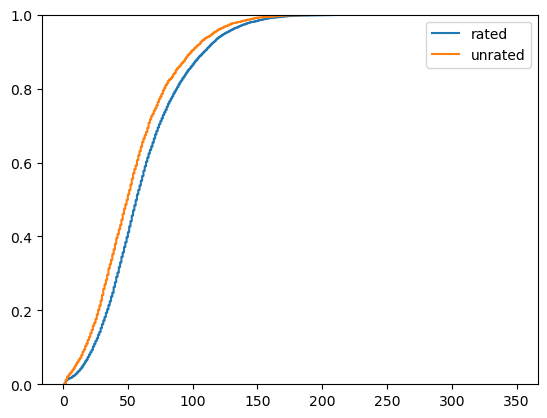

Тест Колмогорова-Смирнова
	Результат: reject
	Подробный результат:
		 Statistic: 0.10439670838635423 
		 P-value: 0.0
	Результат ks_2samp из scipy: KstestResult(statistic=0.10439670838635423, pvalue=2.739935850453732e-30, statistic_location=41, statistic_sign=-1)

Тест Манна-Уитни
	Результат: reject
	Подробный результат:
		 Statistic: 27131565.5 
		 P-value: 9.411368949300668e-42
	Результат mannwhitneyu из scipy: MannwhitneyuResult(statistic=35921399.5, pvalue=9.321578122350876e-42)


In [225]:
def main():
    data = pd.read_csv('chess_games.csv')
    sample1 = data[data['rated'] == True]['turns'].to_numpy()
    sample2 = data[data['rated'] == False]['turns'].to_numpy()

    print_empirical_function(sample1, sample2, label1="rated", label2="unrated")
    first_test(sample1, sample2)
    print()
    second_test(sample1, sample2)
    
if __name__ == '__main__':
    main()